In [1]:
import re
import warnings
warnings.filterwarnings("ignore")


import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib.transforms as transforms

import seaborn as sns

from scipy.ndimage.filters import gaussian_filter1d
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA #мультфакторная анова
from statsmodels.formula.api import ols #линейные модели 

from scipy.stats import f_oneway as ANOVA

import scipy

In [31]:
def aov_for_nominal(df, agrochem_property):
    """
    input - dataframe by agrochemical_proprerty
    output - resul of MANOVA
    """
    dispers = df.copy()
    agrochem_property_ = re.sub(r'[\(),.%№ /-]', '' , agrochem_property)
    dispers.columns = dispers.columns.str.replace(r'[\(),.%№ /-]', '' )
    reg = ols('{} ~ Типобработки  *  Рельеф'.format(agrochem_property_) ,  data=dispers).fit()
    aov = sm.stats.anova_lm(reg)
    aov = aov[["PR(>F)"]]
    aov.columns = ['p-value']
    aov = aov.iloc[:4,:]
    aov['p-value'] = round(aov['p-value'] , 3)
    return aov

In [25]:
agrochemistry_total = pd.read_csv('ready_data/агрохимия_для_статьи.csv')
agrochemistry_total['GPS №'] = agrochemistry_total['GPS №'].astype(int)

agrochemistry_total = agrochemistry_total[agrochemistry_total['GPS №'].isin([585, 526, 584, 527])]

agrochemistry_total['Рельеф'] = 'рельеф'

agrochemistry_total['Рельеф'][agrochemistry_total['GPS №'].isin([585, 526])] = 'Плакор'
agrochemistry_total['Рельеф'][agrochemistry_total['GPS №'].isin([584, 527])] = 'Тальвег'

agrochemistry_total = agrochemistry_total[agrochemistry_total['Глубина'].isin(["0-10", "10-20"])]

agrochemistry_total['Гумус, %'] = agrochemistry_total['Органический углерод, %'] * 1.724

agrochem_columns = ['Год', 
                    'GPS №',
                    'Тип обработки',
                    "Рельеф", 
                    "рН солевой вытяжки, ед. рН",
                    "рН водной вытяжки, ед. рН",
                    'Фосфор (подвижная форма), мг/кг',
                    'Калий (подвижная форма), млн-1',
                    'Общий азот, %',
                    'Гумус, %']

агрохимия_для_статьи = agrochemistry_total[agrochem_columns]

In [26]:
агрохимия_для_статьи.groupby(['Рельеф','Тип обработки']).count()

Год  GPS №  рН солевой вытяжки, ед. рН  \
Рельеф  Тип обработки                                           
Плакор  ПП              10     10                          10   
        ТТ              10     10                           9   
Тальвег ПП              10     10                          10   
        ТТ              10     10                          10   

                       рН водной вытяжки, ед. рН  \
Рельеф  Тип обработки                              
Плакор  ПП                                    10   
        ТТ                                     7   
Тальвег ПП                                    10   
        ТТ                                    10   

                       Фосфор (подвижная форма), мг/кг  \
Рельеф  Тип обработки                                    
Плакор  ПП                                          10   
        ТТ                                          10   
Тальвег ПП                                          10   
        ТТ                                          10   

                       Калий (подвижная форма), млн-1  Общий азот, %  Гумус, %  
Рельеф  Тип обработки                                                           
Плакор  ПП                                         10             10        10  
        ТТ                                         10             10        10  
Тальвег ПП                                         10             10        10  
        ТТ                                         10             10        10

In [27]:
агрохимия_для_статьи.groupby(['Рельеф','Тип обработки']).mean()

Год  GPS №  рН солевой вытяжки, ед. рН  \
Рельеф  Тип обработки                                            
Плакор  ПП             2020    526                    7.346000   
        ТТ             2021    585                    7.132222   
Тальвег ПП             2020    527                    7.248000   
        ТТ             2021    584                    7.199000   

                       рН водной вытяжки, ед. рН  \
Рельеф  Тип обработки                              
Плакор  ПП                              8.252000   
        ТТ                              8.041429   
Тальвег ПП                              8.251000   
        ТТ                              8.589000   

                       Фосфор (подвижная форма), мг/кг  \
Рельеф  Тип обработки                                    
Плакор  ПП                                   15.582923   
        ТТ                                   17.600000   
Тальвег ПП                                   12.430213   
        ТТ                                   17.500000   

                       Калий (подвижная форма), млн-1  Общий азот, %  Гумус, %  
Рельеф  Тип обработки                                                           
Плакор  ПП                                 323.416072          0.159  2.069041  
        ТТ                                 346.160595          0.151  1.955775  
Тальвег ПП                                 340.722368          0.181  2.450459  
        ТТ                                 299.809966          0.116  1.868333

In [28]:
агрохимия_для_статьи.groupby(['Рельеф','Тип обработки']).std()

Год  GPS №  рН солевой вытяжки, ед. рН  \
Рельеф  Тип обработки                                           
Плакор  ПП             0.0    0.0                    0.091068   
        ТТ             0.0    0.0                    0.131413   
Тальвег ПП             0.0    0.0                    0.093903   
        ТТ             0.0    0.0                    0.269132   

                       рН водной вытяжки, ед. рН  \
Рельеф  Тип обработки                              
Плакор  ПП                              0.257242   
        ТТ                              0.125224   
Тальвег ПП                              0.077237   
        ТТ                              0.217279   

                       Фосфор (подвижная форма), мг/кг  \
Рельеф  Тип обработки                                    
Плакор  ПП                                    5.548041   
        ТТ                                    5.979967   
Тальвег ПП                                    3.921683   
        ТТ                                    6.145821   

                       Калий (подвижная форма), млн-1  Общий азот, %  Гумус, %  
Рельеф  Тип обработки                                                           
Плакор  ПП                                  63.360780       0.042282  0.456671  
        ТТ                                  59.495386       0.008756  0.162102  
Тальвег ПП                                  55.627444       0.043063  1.095135  
        ТТ                                  77.797000       0.023664  0.258309

In [29]:
агрохимия_для_статьи.groupby(['Рельеф','Тип обработки']).std() / агрохимия_для_статьи.groupby(['Рельеф','Тип обработки']).mean() * 100

Год  GPS №  рН солевой вытяжки, ед. рН  \
Рельеф  Тип обработки                                           
Плакор  ПП             0.0    0.0                    1.239692   
        ТТ             0.0    0.0                    1.842529   
Тальвег ПП             0.0    0.0                    1.295572   
        ТТ             0.0    0.0                    3.738469   

                       рН водной вытяжки, ед. рН  \
Рельеф  Тип обработки                              
Плакор  ПП                              3.117326   
        ТТ                              1.557231   
Тальвег ПП                              0.936093   
        ТТ                              2.529731   

                       Фосфор (подвижная форма), мг/кг  \
Рельеф  Тип обработки                                    
Плакор  ПП                                   35.603342   
        ТТ                                   33.977083   
Тальвег ПП                                   31.549602   
        ТТ                                   35.118975   

                       Калий (подвижная форма), млн-1  Общий азот, %  \
Рельеф  Тип обработки                                                  
Плакор  ПП                                  19.591104      26.592529   
        ТТ                                  17.187221       5.798643   
Тальвег ПП                                  16.326326      23.791857   
        ТТ                                  25.948770      20.400275   

                        Гумус, %  
Рельеф  Тип обработки             
Плакор  ПП             22.071639  
        ТТ              8.288361  
Тальвег ПП             44.690999  
        ТТ             13.825637

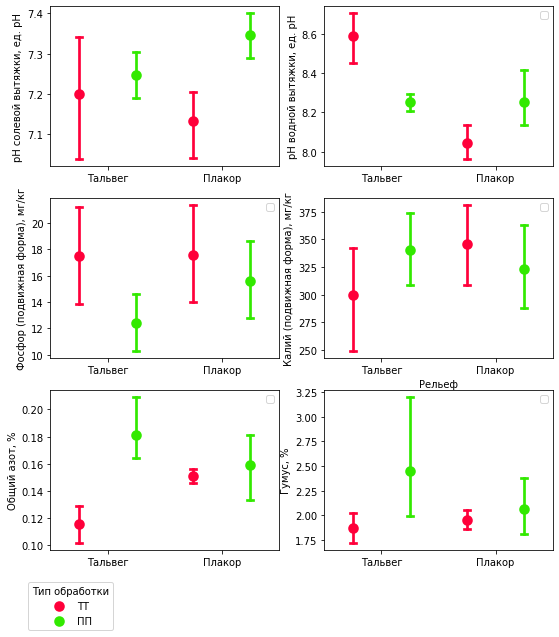

In [30]:
fig, ax  = plt.subplots(3,2, figsize = (9,10))
sns.pointplot(
    data = агрохимия_для_статьи,
    x = 'Рельеф',
    y = "рН солевой вытяжки, ед. рН", 
    hue = 'Тип обработки', 
    palette = "prism_r",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[0,0])
ax[0,0].set_xlabel('')
ax[0,0].legend(bbox_to_anchor=(-0.1, -2.6), loc=2, borderaxespad=0., title = 'Тип обработки')

sns.pointplot(
    data = агрохимия_для_статьи,
    x = 'Рельеф',
    y = "рН водной вытяжки, ед. рН", 
    hue = 'Тип обработки', 
    palette = "prism_r",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[0,1])
ax[0,1].set_xlabel('')
ax[0,1].legend([],[])

sns.pointplot(
    data = агрохимия_для_статьи,
    x = 'Рельеф',
    y = "Фосфор (подвижная форма), мг/кг", 
    hue = 'Тип обработки', 
    palette = "prism_r",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[1,0])
ax[1,0].set_xlabel('')
ax[1,0].legend([],[])

sns.pointplot(
    data = агрохимия_для_статьи,
    x = 'Рельеф',
    y = "Калий (подвижная форма), млн-1", 
    hue = 'Тип обработки', 
    palette = "prism_r",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[1,1])
ax[1,1].set_ylabel('Калий (подвижная форма), мг/кг')

ax[1,1].legend([],[])

sns.pointplot(
    data = агрохимия_для_статьи,
    x = 'Рельеф',
    y = "Общий азот, %", 
    hue = 'Тип обработки', 
    palette = "prism_r",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[2,0])
ax[2,0].set_xlabel('')
ax[2,0].legend([],[])

sns.pointplot(
    data = агрохимия_для_статьи,
    x = 'Рельеф',
    y = 'Гумус, %', 
    hue = 'Тип обработки', 
    palette = "prism_r",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[2,1])
ax[2,1].set_xlabel('')
ax[2,1].legend([],[])





In [33]:
aov_for_nominal(агрохимия_для_статьи, 'рН солевой вытяжки, ед. рН')

,p-value
Типобработки,0.019
Рельеф,0.737
Типобработки:Рельеф,0.127
Residual,NaN


In [34]:
aov_for_nominal(агрохимия_для_статьи, 'рН водной вытяжки, ед. рН')

,p-value
Типобработки,0.08
Рельеф,0.00
Типобработки:Рельеф,0.00
Residual,NaN


In [35]:
aov_for_nominal(агрохимия_для_статьи, 'Фосфор (подвижная форма), мг/кг')

,p-value
Типобработки,0.048
Рельеф,0.353
Типобработки:Рельеф,0.383
Residual,NaN


In [36]:
aov_for_nominal(агрохимия_для_статьи, 'Калий (подвижная форма), млн-1')

,p-value
Типобработки,0.659
Рельеф,0.482
Типобработки:Рельеф,0.128
Residual,NaN


In [37]:
aov_for_nominal(агрохимия_для_статьи, 'Общий азот, %')

,p-value
Типобработки,0.001
Рельеф,0.534
Типобработки:Рельеф,0.009
Residual,NaN


In [38]:
aov_for_nominal(агрохимия_для_статьи, 'Гумус, %')

,p-value
Типобработки,0.081
Рельеф,0.453
Типобработки:Рельеф,0.234
Residual,NaN


In [31]:
for ind, prop in enumerate(agrochem_prop):
    sample_list = []
    ab_test = pd.DataFrame()
    for value  in ['ПП','ТТ']:
        sample = плакоры[плакоры['Тип обработки'] == value][prop]
        sample_list.append(sample) 
    p_val = ANOVA(*sample_list)[1]
    local_df = pd.DataFrame({"свойство":prop, 'p-value' : p_val}, index = [ind])
    print(local_df)
    ab_test = ab_test.append(local_df)

                     свойство   p-value
0  рН солевой вытяжки, ед. рН  0.000022
                    свойство   p-value
1  рН водной вытяжки, ед. рН  0.005276
                          свойство   p-value
2  Фосфор (подвижная форма), мг/кг  0.642839
                         свойство   p-value
3  Калий (подвижная форма), млн-1  0.822972
        свойство   p-value
4  Общий азот, %  0.375377
   свойство   p-value
5  Гумус, %  0.433698


In [32]:
тальвеги.groupby(['Тип обработки','Глубина']).mean()

рН солевой вытяжки, ед. рН  рН водной вытяжки, ед. рН  \
Тип обработки Глубина                                                          
ПП            0-10                          7.246                      8.236   
              10-20                         7.250                      8.266   
              20-30                         7.230                      8.124   
ТТ            0-10                          7.200                      8.504   
              10-20                         7.198                      8.674   
              20-30                         7.248                      8.640   

                       Фосфор (подвижная форма), мг/кг  \
Тип обработки Глубина                                    
ПП            0-10                           11.937603   
              10-20                          12.922824   
              20-30                          11.937603   
ТТ            0-10                           20.960000   
              10-20                          14.040000   
              20-30                          10.360000   

                       Калий (подвижная форма), млн-1  Общий азот, %  Гумус, %  
Тип обработки Глубина                                                           
ПП            0-10                         351.741376          0.196  2.721851  
              10-20                        329.703360          0.166  2.179067  
              20-30                        281.072355          0.162  2.137691  
ТТ            0-10                         332.031896          0.124  1.906296  
              10-20                        267.588037          0.108  1.830371  
              20-30                        227.116299          0.094  1.598976

In [33]:
тальвеги.groupby(['Тип обработки','Глубина']).std()

рН солевой вытяжки, ед. рН  рН водной вытяжки, ед. рН  \
Тип обработки Глубина                                                          
ПП            0-10                       0.109453                   0.061074   
              10-20                      0.088600                   0.095551   
              20-30                      0.163248                   0.266327   
ТТ            0-10                       0.300083                   0.222104   
              10-20                      0.270037                   0.197053   
              20-30                      0.272158                   0.205426   

                       Фосфор (подвижная форма), мг/кг  \
Тип обработки Глубина                                    
ПП            0-10                            3.980710   
              10-20                           4.260443   
              20-30                           6.352579   
ТТ            0-10                            5.022748   
              10-20                           5.461502   
              20-30                           1.872966   

                       Калий (подвижная форма), млн-1  Общий азот, %  Гумус, %  
Тип обработки Глубина                                                           
ПП            0-10                          61.972610       0.058566  1.560854  
              10-20                         53.087453       0.013416  0.279412  
              20-30                         61.776260       0.008367  0.165318  
ТТ            0-10                          68.842170       0.019494  0.303533  
              10-20                         79.265146       0.026833  0.233223  
              20-30                         52.180509       0.018166  0.326209

In [34]:
тальвеги.groupby(['Тип обработки','Глубина']).std() / тальвеги.groupby(['Тип обработки','Глубина']).mean() * 100

рН солевой вытяжки, ед. рН  рН водной вытяжки, ед. рН  \
Тип обработки Глубина                                                          
ПП            0-10                       1.510533                   0.741546   
              10-20                      1.222072                   1.155952   
              20-30                      2.257929                   3.278273   
ТТ            0-10                       4.167824                   2.611754   
              10-20                      3.751556                   2.271770   
              20-30                      3.754940                   2.377620   

                       Фосфор (подвижная форма), мг/кг  \
Тип обработки Глубина                                    
ПП            0-10                           33.345976   
              10-20                          32.968358   
              20-30                          53.214865   
ТТ            0-10                           23.963494   
              10-20                          38.899584   
              20-30                          18.078818   

                       Калий (подвижная форма), млн-1  Общий азот, %  \
Тип обработки Глубина                                                  
ПП            0-10                          17.618800      29.880715   
              10-20                         16.101581       8.082173   
              20-30                         21.978775       5.164568   
ТТ            0-10                          20.733601      15.720636   
              10-20                         29.622081      24.845200   
              20-30                         22.975238      19.325428   

                        Гумус, %  
Тип обработки Глубина             
ПП            0-10     57.345306  
              10-20    12.822534  
              20-30     7.733466  
ТТ            0-10     15.922663  
              10-20    12.741819  
              20-30    20.401125

In [35]:
тальвеги.sort_values(by =['GPS №'], inplace =True)

KeyError: 'GPS №'

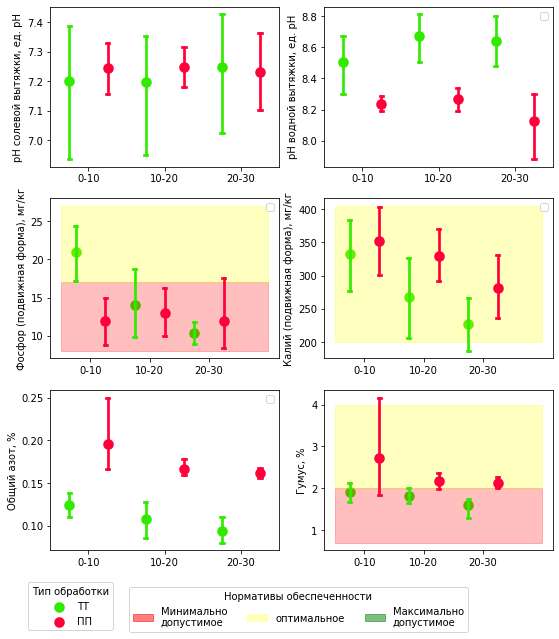

In [36]:
agrochem_prop = [
    "рН солевой вытяжки, ед. рН",
    "рН водной вытяжки, ед. рН", 
    "Фосфор (подвижная форма), мг/кг", 
    "Калий (подвижная форма), млн-1", 
    "Общий азот, %",
    'Гумус, %']
fig, ax  = plt.subplots(3,2, figsize = (9,10))
sns.pointplot(
    data = тальвеги,
    x = 'Глубина',
    y = "рН солевой вытяжки, ед. рН", 
    hue = 'Тип обработки', 
    palette = "prism",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[0,0])
ax[0,0].set_xlabel('')
ax[0,0].legend(bbox_to_anchor=(-0.1, -2.6), loc=2, borderaxespad=0., title = 'Тип обработки')

sns.pointplot(
    data = тальвеги,
    x = 'Глубина',
    y = "рН водной вытяжки, ед. рН", 
    hue = 'Тип обработки', 
    palette = "prism",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[0,1])
ax[0,1].set_xlabel('')
ax[0,1].legend([],[])

sns.pointplot(
    data = тальвеги,
    x = 'Глубина',
    y = "Фосфор (подвижная форма), мг/кг", 
    hue = 'Тип обработки', 
    palette = "prism",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[1,0])
ax[1,0].fill_between(x = [-0.5,3] , y1 = 8,y2 = 17, color='Red', alpha = 0.25)
ax[1,0].fill_between(x = [-0.5,3] , y1 = 17,y2 = 27, color='Yellow', alpha = 0.25)
ax[1,0].set_xlabel('')
ax[1,0].legend([],[])

sns.pointplot(
    data = тальвеги,
    x = 'Глубина',
    y = "Калий (подвижная форма), млн-1", 
    hue = 'Тип обработки', 
    palette = "prism",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[1,1])
ax[1,1].fill_between(x = [-0.5,3] , y1 = 200,y2 = 405, color='Yellow', alpha = 0.25)
ax[1,1].set_xlabel('')
ax[1,1].set_ylabel('Калий (подвижная форма), мг/кг')

ax[1,1].legend([],[])

sns.pointplot(
    data = тальвеги,
    x = 'Глубина',
    y = "Общий азот, %", 
    hue = 'Тип обработки', 
    palette = "prism",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[2,0])
ax[2,0].set_xlabel('')
ax[2,0].legend([],[])

sns.pointplot(
    data = тальвеги,
    x = 'Глубина',
    y = 'Гумус, %', 
    hue = 'Тип обработки', 
    palette = "prism",
    scale = 1.2,
    ci = 95,
    dodge= 0.5,
    join = False,
    capsize = .05,
    ax = ax[2,1])
ax[2,1].fill_between(x = [-0.5,3] , y1 = 0.7,y2 = 2, color='Red', alpha = 0.25)
ax[2,1].fill_between(x = [-0.5,3] , y1 = 2,y2 = 4, color='Yellow', alpha = 0.25)
ax[2,1].set_xlabel('')
ax[2,1].legend([],[])


a = mpatches.Patch(color="Red", label= 'Минимально\nдопустимое',alpha=0.5)
b = mpatches.Patch(color="Yellow", label= "оптимальное",alpha=0.25)
c = mpatches.Patch(color="Green", label= 'Максимально\nдопустимое',alpha=0.5)

plt.legend(handles=[a,b,c], title='Нормативы обеспеченности',bbox_to_anchor=(0.65,-0.20),ncol = 3)

In [37]:
aov_for_nominal(тальвеги, 'рН солевой вытяжки, ед. рН')

,p-value
Глубина,0.983
Типобработки,0.740
Глубина:Типобработки,0.924
Residual,NaN


In [38]:
aov_for_nominal(тальвеги, 'рН водной вытяжки, ед. рН')

,p-value
Глубина,0.446
Типобработки,0.000
Глубина:Типобработки,0.355
Residual,NaN


In [39]:
aov_for_nominal(тальвеги, 'Фосфор (подвижная форма), мг/кг')

,p-value
Глубина,0.059
Типобработки,0.110
Глубина:Типобработки,0.049
Residual,NaN


In [40]:
aov_for_nominal(тальвеги, 'Калий (подвижная форма), млн-1')

,p-value
Глубина,0.018
Типобработки,0.063
Глубина:Типобработки,0.734
Residual,NaN


In [41]:
aov_for_nominal(тальвеги, 'Общий азот, %')

,p-value
Глубина,0.059
Типобработки,0.000
Глубина:Типобработки,0.859
Residual,NaN


In [42]:
aov_for_nominal(тальвеги, 'Гумус, %')

,p-value
Глубина,0.343
Типобработки,0.032
Глубина:Типобработки,0.747
Residual,NaN
